In [1]:
!pip install matplotlib numpy

In [2]:
import os
from typing import List, Tuple
from matplotlib import pyplot as plt
import numpy as np

files_to_read = ['rqc_off_stats.txt', 'rqc_on_stats copy.txt']

def read_file(file_name):
    with open(file_name) as f:
        lines = f.readlines()
        return lines

def get_rocksdb_compact_write_bytes(lines) -> List[str]:
    return [line for line in lines if 'rocksdb.compact.write.bytes' in line]

def get_rocksdb_flush_write_bytes(lines) -> List[str]:
    return [line for line in lines if 'rocksdb.flush.write.bytes' in line]

def transform_bytes(lines) -> List[int]:
    return [int(line.strip(' \n').split(' : ')[1]) for line in lines]

def get_total_bytes(compact_bytes, flush_bytes) -> List[int]:
    return [compact_bytes[i] + flush_bytes[i] for i in range(len(compact_bytes))]

def get_levels_stats(lines) -> List[Tuple[str, int, int]]:
    return [line.strip(' \t') for line in lines if 'Level-' in line or 'Total:' in line]


In [3]:
experiments = os.listdir('./')

results = list()

for experiment in experiments:

    if not os.path.isdir(experiment):
        continue
    
    i, inserts, u, updates, s, range_queries, y, selectivity, t, size_ratio, *others = experiment.split(' ')

    if len(others) == 2:
        rq, rqc = others
        utl, utl_value = None, 0
        ltu, ltu_value = None, 0
    else:
        w, wc, utl, utl_value, ltu, ltu_value, rq, rqc = others

    if rqc =='0':
        approach = 'vanilla'
        lines = read_file(f'{experiment}/rqc_off_stats.txt')
    else:
        approach = 'rqdc'
        lines = read_file(f'{experiment}/rqc_on_stats.txt')
    
    compact_write_bytes = get_rocksdb_compact_write_bytes(lines)
    flush_write_bytes = get_rocksdb_flush_write_bytes(lines)
    levels_details = get_levels_stats(lines)

    compact_bytes = transform_bytes(compact_write_bytes)
    flush_bytes = transform_bytes(flush_write_bytes)

    results.append({
        'inserts': inserts,
        'updates': updates,
        'range_queries': range_queries,
        'size_ratio': size_ratio,
        'rqc': rqc,
        'utl': utl_value,
        'ltu': ltu_value,
        'approach': approach,
        'compact_write_bytes': compact_bytes,
        'flush_write_bytes': flush_bytes,
        'total_write_bytes': get_total_bytes(compact_bytes, flush_bytes),
        'levels_details': levels_details,
    })

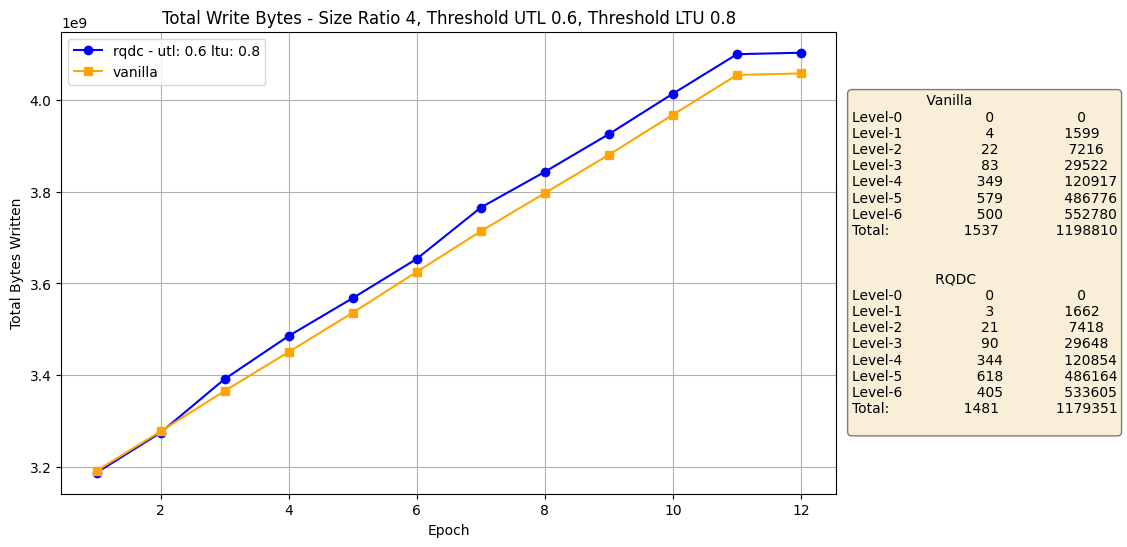

In [4]:
size_ratios = ['4']
utl_ltu_values_rqdc = [(0.6, 0.8)]
utl_ltu_value_vanilla = [(0, 0)]

for size_ratio in size_ratios:
    rqdc_data = [exp for exp in results if exp['approach'] == 'rqdc' and exp['size_ratio'] == size_ratio]
    vanilla_data = [exp for exp in results if exp['approach'] == 'vanilla' and exp['size_ratio'] == size_ratio]

    for utl, ltu in utl_ltu_values_rqdc:
        rqdc_data_utl_ltu = [exp for exp in rqdc_data if exp['utl'] == str(utl) and exp['ltu'] == str(ltu)]
        rqdc_epochs = range(1, len(rqdc_data_utl_ltu[0]['total_write_bytes']) + 1)
        rqdc_total_bytes = rqdc_data_utl_ltu[0]['total_write_bytes']
        vanilla_total_bytes = vanilla_data[0]['total_write_bytes']

        vanilla_levels_info_string = "                 Vanilla\n" + "".join(vanilla_data[0]['levels_details'])
        info_str = vanilla_levels_info_string + "\n\n                   RQDC\n" + "".join(rqdc_data_utl_ltu[0]['levels_details'])

        plt.figure(figsize=(10, 6))
        plt.plot(rqdc_epochs, rqdc_total_bytes, label=f'rqdc - utl: {utl} ltu: {ltu}', marker='o', color='blue')
        plt.plot(rqdc_epochs, vanilla_total_bytes, label='vanilla', marker='s', color='orange')
        plt.title(f'Total Write Bytes - Size Ratio {size_ratio}, Threshold UTL {utl}, Threshold LTU {ltu}')
        plt.xlabel('Epoch')
        plt.ylabel('Total Bytes Written')
        plt.legend()
        plt.grid(True)

        plt.text(1.02, 0.5, info_str, transform=plt.gca().transAxes, fontsize=10, verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.show()

        # epochs = np.arange(1, 13)

        # bar_width = 0.35
        # fig, ax = plt.subplots(figsize=(10, 6))

        # bar2 = ax.bar(epochs + bar_width/2, rqdc_total_bytes, bar_width, label='RQDC', color='blue')
        # bar1 = ax.bar(epochs - bar_width/2, vanilla_total_bytes, bar_width, label='Vanilla', color='orange')

        # # Adding labels and title
        # ax.set_xlabel('Epoch')
        # ax.set_ylabel('Total Bytes Written')
        # ax.set_title('Comparison between Vanilla and RQDC by Total Bytes Written'
        #              f'\nSize Ratio {size_ratio}, Threshold UTL {utl}, Threshold LTU {ltu}')
        # ax.set_xticks(epochs)
        # ax.legend()

        # Show the plot
        # plt.show()

    #     break
    # break